In [1]:
using OrdinaryDiffEq, ParameterizedFunctions
using Optim, LsqFit
using Plots, LaTeXStrings
using DelimitedFiles, DataFrames
using Statistics
using Printf

In [2]:
ENV["COLUMNS"]=120
figdir = "figures/";

In [3]:
include("VirusLoadCurve.jl")
import .VirusLoadCurve

In [4]:
io = IOBuffer(append=true)
print(io, @sprintf "\nData & \$\\mx\$ & \$\\mn\$ & \$a_1\$ & \$a_2\$ & \$\\alpha\$ & \$b_1\$ & \$b_2\$ \\\\ \n")
function VLFResultsLatex(dataname, result)
    print(io, @sprintf "%s & " dataname)
    print(io, @sprintf "%.2f \$\\cdot 10^{%d}\$ & " 10^rem(result.fit.minimizer[6], 1) floor(result.fit.minimizer[6]))
    print(io, @sprintf "\$10^{-7}\$ & ")
    print(io, @sprintf "%.2f & " result.fit.minimizer[1])
    print(io, @sprintf "%.2f & " result.fit.minimizer[2])
    print(io, @sprintf "%.2f & " result.fit.minimizer[5])
    print(io, @sprintf "%.2f & " result.fit.minimizer[3])
    print(io, @sprintf "%.2f \\\\ \n" result.fit.minimizer[4])
end

VLFResultsLatex (generic function with 1 method)

# Viral load data fitting

Data for influenza from

*Smith, A. P., Moquin, D. J., Bernhauerova, V., & Smith, A. M. (2018). Influenza virus infection model with density dependence supports biphasic viral decay. Frontiers in Microbiology, 9(JUL), 1–10. https://doi.org/10.3389/fmicb.2018.01554*


## Data set

10 mice with 13 data points each

In [5]:
tdata = [4.0/24.0, 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.]
RAWDATA = readdlm("../../data/Smith2018/Virus_Best10.txt", ' ', Float64, '\n')
DataFrame(RAWDATA, Symbol.(tdata))

,0.16666666666666666,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,4.18551,5.67816,6.00515,5.9364,5.97712,5.44716,5.19848,4.00515,0.0,0.0,0.0
2,0.0,3.99136,5.47712,5.84488,5.82436,5.81012,5.0874,4.49136,0.0,0.0,0.0,0.0
3,0.0,3.49136,5.44716,5.81012,5.83815,5.78016,5.2954,5.01851,2.94716,0.0,0.0,0.0
4,0.0,3.29788,5.77233,6.24612,5.49136,5.9624,5.14412,5.51851,3.23882,0.0,0.0,0.0
5,0.0,4.75515,5.9624,6.44716,5.78016,5.83244,5.99136,4.96982,0.0,0.0,0.0,0.0
6,0.0,4.30151,5.49136,6.86448,5.70812,5.80282,4.9624,4.47712,0.0,0.0,0.0,0.0
7,0.0,3.49136,5.7954,5.74951,6.03148,5.82436,5.2954,5.17215,3.26036,0.0,0.0,0.0
8,0.0,4.00515,6.03148,5.83815,6.26036,6.1294,5.18551,4.83815,0.0,0.0,0.0,0.0
9,0.0,3.49136,6.18551,5.78784,5.59921,5.97712,5.34488,5.47712,0.0,0.0,0.0,0.0


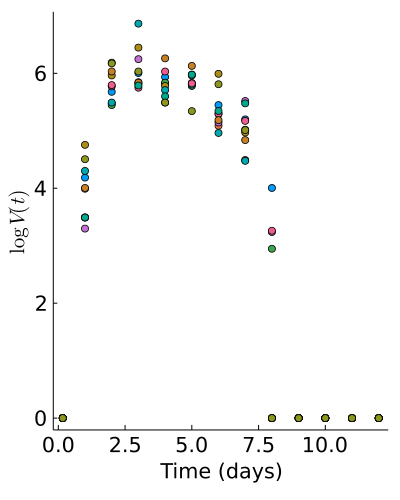

In [6]:
plt = plot(legend=:none, grid=:none, 
    xaxis=("Time (days)", font(14)), yaxis=(L"\log\,V(t)", font(14)), size = (400, 500))
[plot!(tdata, RAWDATA[i, :], seriestype=:scatter) for i in 1:size(RAWDATA, 1)]
savefig(figdir*"Smith2018Data.pdf")
display(plt)

### Average of data

In [7]:
vdata_avg = mean(RAWDATA, dims=1)[:]
vdata_std = std(RAWDATA, dims=1)[:];

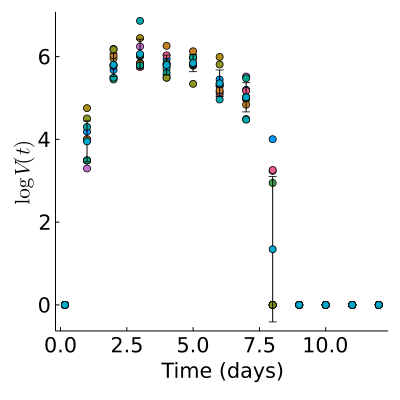

In [8]:
plot!(tdata, vdata_avg, yerrors=vdata_std,
    seriestype=:scatter, legend=:none, grid=:off, size = (400, 400),
    xlabel="Time (days)", ylabel=L"\log\,V(t)")

### Combined data

In [9]:
ttdata = repeat(tdata, inner=10)
tend = ttdata[end]
vvdata = reshape(RAWDATA, 1, :)[:];

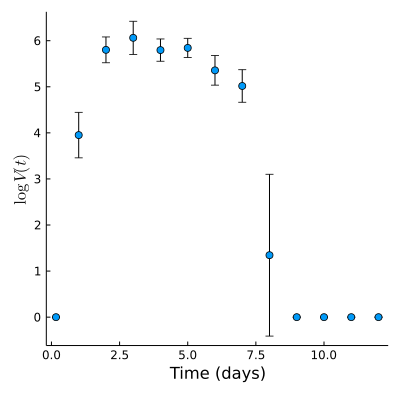

In [10]:
plot(tdata, vdata_avg, yerrors=vdata_std,
    seriestype=:scatter, legend=:none, grid=:off,  size = (400, 400),
    xlabel="Time (days)", ylabel=L"\log\,V(t)")

We'll use the combined data. But the average data shows similar results.

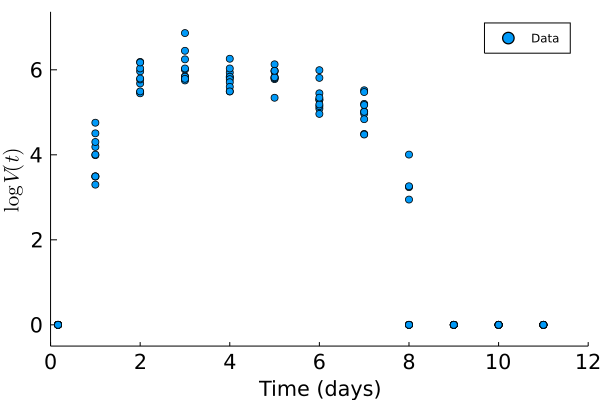

In [11]:
data = VirusLoadCurve.VirusLoadData(ttdata, vvdata)
plot(data)

## Fitting models to data

### Standard virus load function

Consider a virus load function with three main phases given by

$$V(t)=v_1(t)v_2(t)v_3(t),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function.

In [12]:
resultVLF = VirusLoadCurve.fitVLF(data, ϵ=0.2)
summary(resultVLF)

Fitting the VLF to data 100%|███████████████████████████| Time: 0:02:22
Finding possible parameter values 100%|█████████████████| Time: 0:00:36


RSS = 3.61923e+01
a₁ = 0.94355438433998, CI=(0.7531713461432457, 1.096612985449672)
a₂ = 1.516369054715881, CI=(1.0349659511477052, 2.606374389825536)
b₁ = 6.250968125386993, CI=(5.569956343165865, 7.913137113116644)
b₂ = 7.634183338780164, CI=(7.392808323891499, 7.984810051400198)
α = 0.25511854497317366, CI=(0.025141058374900188, 0.5199022141003514)
logVmax = 6.047246947715047, CI=(5.573426870084113, 6.472876743275332)


In [13]:
# VLFResultsLatex("Mice data", resultVLF)
# print(read(io, String))

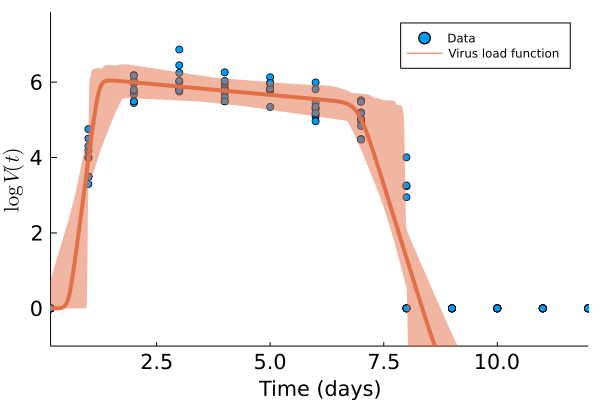

In [14]:
pt = plot(data)
plot!(pt, resultVLF)
savefig(figdir*"Smith2018VLFDataFit.pdf")
savefig(figdir*"Smith2018VLFDataFit.png")
display(pt)

### Each subject separately

Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:40
Finding possible parameter values 100%|█████████████████| Time: 0:00:09


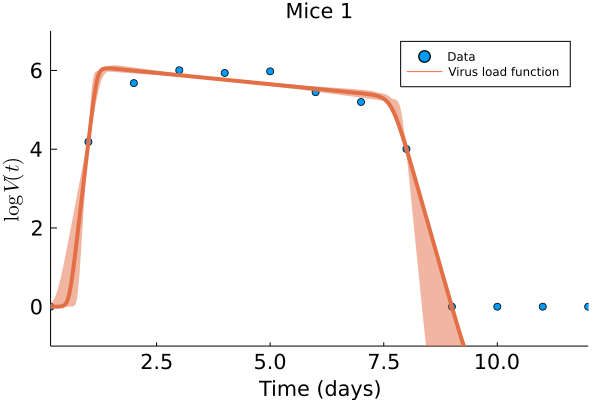

RSS = 3.08783e-01
a₁ = 0.9247690376612284, CI=(0.8470185340489164, 0.9461663477889852)
a₂ = 1.4548145005041704, CI=(1.2308272110792922, 1.707361474278152)
b₁ = 7.008503010112522, CI=(6.919804501449556, 7.655667671370808)
b₂ = 8.338770276320663, CI=(8.112419305355282, 8.295906833416312)
α = 0.2647212883265548, CI=(0.18870402133965725, 0.35346844965436536)
logVmax = 6.057431857222605, CI=(5.98710651638349, 6.132320498696503)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:45
Finding possible parameter values 100%|█████████████████| Time: 0:00:09


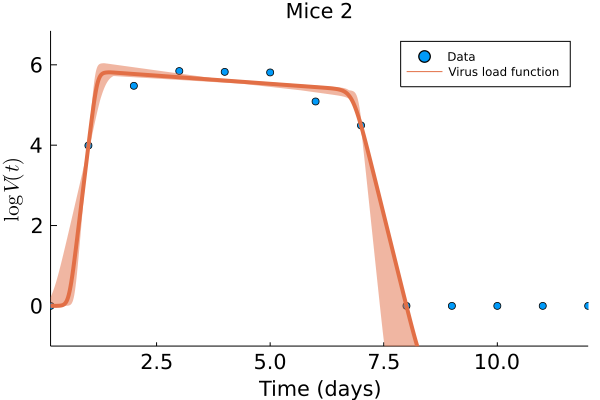

RSS = 3.65568e-01
a₁ = 0.9157411343838722, CI=(0.8365535643607763, 0.9522388902612919)
a₂ = 1.472210023029536, CI=(1.3448507962242044, 1.901040697483158)
b₁ = 6.23741234765961, CI=(6.320790025957037, 6.713397964164767)
b₂ = 7.40055829636897, CI=(7.163048889427546, 7.389101676643375)
α = 0.18740364624814876, CI=(0.15671604890924748, 0.35942442849930967)
logVmax = 5.814542589428767, CI=(5.725306303850764, 6.0413365935377294)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:35
Finding possible parameter values 100%|█████████████████| Time: 0:00:09


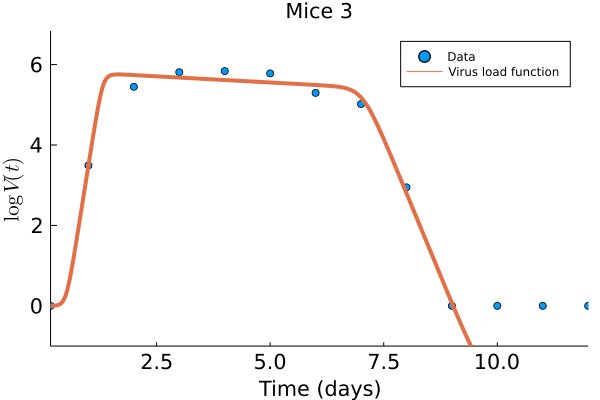

RSS = 2.94830e-01
a₁ = 0.9520937250807602, CI=(-Inf, Inf)
a₂ = 1.6829866577031518, CI=(-Inf, Inf)
b₁ = 6.0673071215681045, CI=(-Inf, Inf)
b₂ = 8.014470613580686, CI=(-Inf, Inf)
α = 0.14105902448502297, CI=(-Inf, Inf)
logVmax = 5.757746907815202, CI=(-Inf, Inf)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:39
Finding possible parameter values 100%|█████████████████| Time: 0:00:09


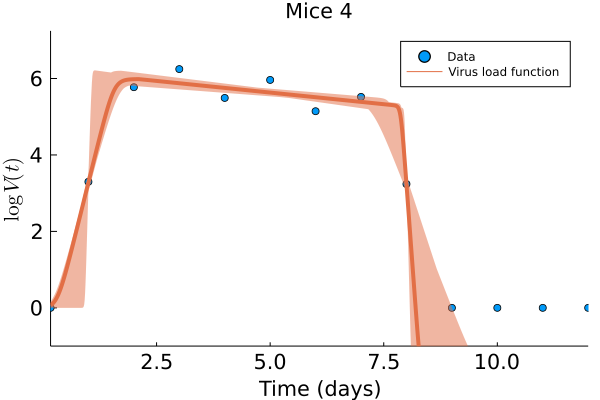

RSS = 5.14309e-01
a₁ = 1.0200821937754307, CI=(0.9501665410141289, 1.0799596863013257)
a₂ = 2.106933090333495, CI=(1.1396224869026232, 2.330603340204212)
b₁ = 7.709688818569189, CI=(6.337600167906319, 7.898969916100532)
b₂ = 8.03649943813219, CI=(8.015236558929747, 8.199254364059454)
α = 0.280521148647217, CI=(0.14931737180169927, 0.38687225546817955)
logVmax = 5.98457656404118, CI=(5.827457041946088, 6.213748396882362)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:49
Finding possible parameter values 100%|█████████████████| Time: 0:00:09


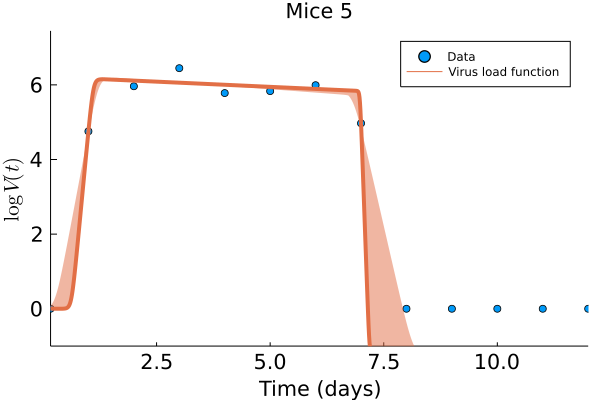

RSS = 2.46807e-01
a₁ = 0.9039960859533229, CI=(0.8207134041075135, 0.8841289479692287)
a₂ = 1.3119952143629636, CI=(1.4585342473599932, 1.6281547904366849)
b₁ = 6.898223460320358, CI=(6.323559535709776, 6.598221757659457)
b₂ = 7.0538594808017026, CI=(7.219084208069809, 7.319033010540803)
α = 0.1282079379845048, CI=(0.1558458084635427, 0.20908313121061142)
logVmax = 6.152372106473122, CI=(6.186242530173703, 6.18979971498409)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:43
Finding possible parameter values 100%|█████████████████| Time: 0:00:09


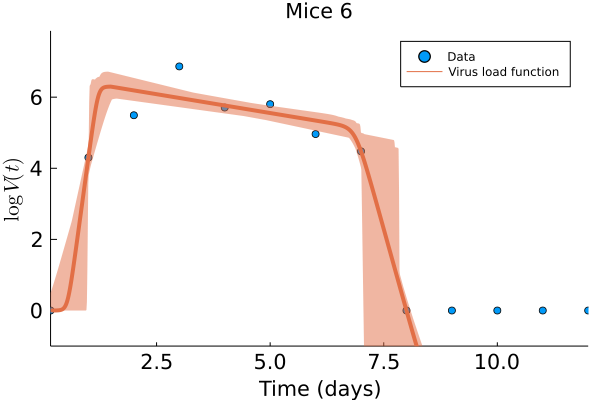

RSS = 1.48325e+00
a₁ = 0.9345555712713993, CI=(0.816955732156952, 0.9981661703838167)
a₂ = 1.4901397995802084, CI=(1.040526131578376, 2.1220872528578996)
b₁ = 6.2805287018904234, CI=(6.015983676546154, 7.820394952347824)
b₂ = 7.470982965474269, CI=(7.027283852345378, 7.842990508832772)
α = 0.48798048900963437, CI=(0.31210473921916243, 0.7266217390093233)
logVmax = 6.297768207075461, CI=(5.969067910139821, 6.71892858147766)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:40
Finding possible parameter values 100%|█████████████████| Time: 0:00:09


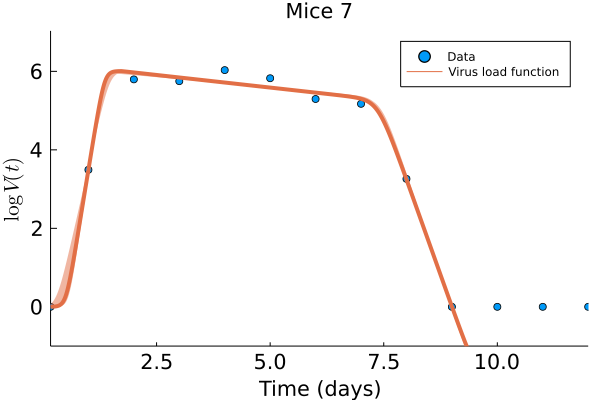

RSS = 2.40066e-01
a₁ = 0.98722486826901, CI=(0.9639274601357978, 1.0000906693099532)
a₂ = 1.7236025258749346, CI=(1.675782441104863, 1.9863745827157147)
b₁ = 6.537453210189601, CI=(6.6259642715790426, 6.672453917576373)
b₂ = 8.209635788595333, CI=(8.195813720072415, 8.23520282989372)
α = 0.29605655898060573, CI=(0.23950738684986328, 0.29419957001794517)
logVmax = 6.007887350541754, CI=(5.937417800421836, 5.999390205932611)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:44
Finding possible parameter values 100%|█████████████████| Time: 0:00:08


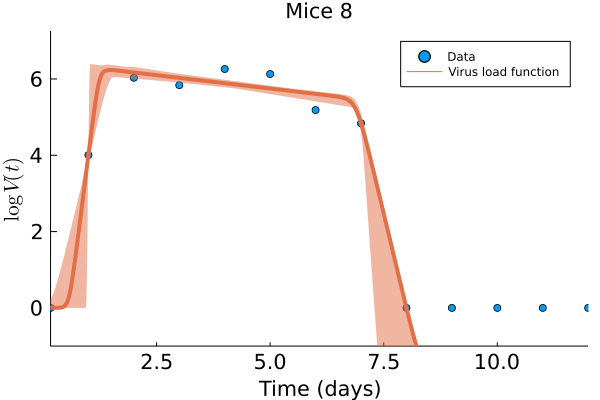

RSS = 5.17274e-01
a₁ = 0.9598880906989042, CI=(0.8986136087721925, 0.9968665775750564)
a₂ = 1.515218183762993, CI=(1.0500610279768106, 1.9992968844335746)
b₁ = 6.352972929386378, CI=(6.435174106956549, 6.822030125722826)
b₂ = 7.4334953853649735, CI=(7.138613519601901, 7.412868159286175)
α = 0.3224850121404142, CI=(0.2340026153884145, 0.44007969946407943)
logVmax = 6.236995125505727, CI=(6.047460942932243, 6.392595779748392)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:49
Finding possible parameter values 100%|█████████████████| Time: 0:00:08


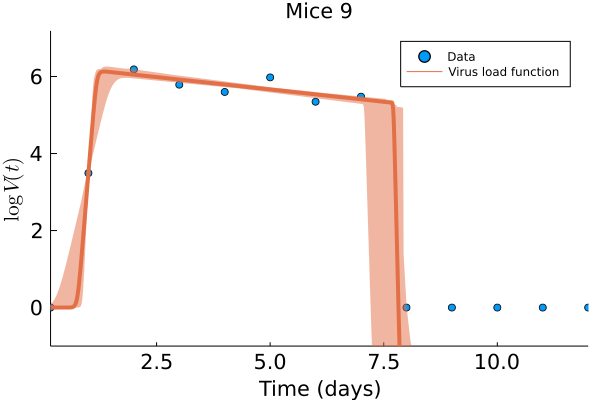

RSS = 2.12887e-01
a₁ = 1.002305948913176, CI=(0.959284976238065, 1.0169447062371793)
a₂ = 1.36318140916555, CI=(1.2052547938171134, 2.0311305041693464)
b₁ = 7.6597920111497935, CI=(6.778034917985341, 7.930044077573188)
b₂ = 7.7684668866629645, CI=(7.136239790831202, 7.931410602320141)
α = 0.2955808747546476, CI=(0.2158117409238454, 0.38703287108721757)
logVmax = 6.131284047154866, CI=(5.9659520257021885, 6.2612577070292454)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:51
Finding possible parameter values 100%|█████████████████| Time: 0:00:08


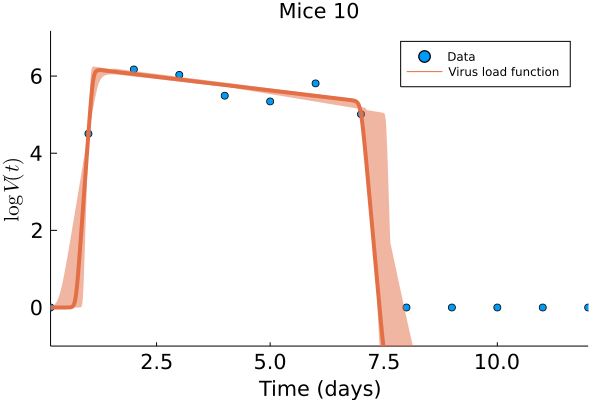

RSS = 2.92479e-01
a₁ = 0.9408486348237362, CI=(0.8402163128469385, 0.9782138211433371)
a₂ = 1.2606012427968691, CI=(1.1176570417251166, 1.6185903830970108)
b₁ = 6.792088828411617, CI=(6.500994268241178, 7.480995927192034)
b₂ = 7.1980897986021946, CI=(7.2389680442718, 7.623841524754828)
α = 0.3253829046600482, CI=(0.3075921390691621, 0.4481732857279428)
logVmax = 6.156615917177213, CI=(6.04737649924859, 6.248636976082885)


In [15]:
ttdata = tdata
k = 1
for vvdata ∈ eachrow(RAWDATA)
    data = VirusLoadCurve.VirusLoadData(ttdata, vvdata[:])
    resultVLF = VirusLoadCurve.fitVLF(data; ϵ=0.2)
    summary(resultVLF)
    pt = plot(data)
    plot!(pt, resultVLF)
    title!(pt, "Mice "*string(k))
    savefig(figdir*"Smith2018"*string(k)*"VLFDataFit.pdf")
    savefig(figdir*"Smith2018"*string(k)*"00VLFDataFit.png")
    display(pt)
    k = k + 1
end

### Standard virus-target ODE Model


The standard viral kinetic model with varying clearance rate reads
$$
\begin{aligned}
\frac{dT}{dt} & = -\beta T V, \\
\frac{dI_1}{dt} & = \beta T V - k I_1, \\
\frac{dI_2}{dt} & = k I_1 - \frac{\delta I_2}{K + I_2}, \\
\frac{dV}{dt} & = p I_2 -c V.
\end{aligned}
$$

*Smith, A. P., Moquin, D. J., Bernhauerova, V., & Smith, A. M. (2018). Influenza virus infection model with density dependence supports biphasic viral decay. Frontiers in Microbiology, 9(JUL), 1–10. https://doi.org/10.3389/fmicb.2018.01554*

In [15]:
#       β     , k     , δ     , K     , p     , c
# par0 = [2.5e-4, 1.5e+0, 1.6e+6, 5.0e+4, 2.1e+0, 1.5e+1]
par0 = [9.9e-5, 1.6e+6, 1.0e+5, 1.7e+0, 1.2e+1]
lb   = [1e-6  , 1e+4  , 1e+2  , 1e-1  , 1e+0  ]
ub   = [1e-1  , 4e+6  , 1e+6  , 1e+3  , 1e+3  ]
resultVTM = VirusLoadCurve.fitVTM(data, par0, lb=lb, ub=ub)
summary(resultVTM)

RSS = 3.57378e+01 (convergence: true)
  β = 2.779e-04 (CI=(9.271e-05, 4.631e-04), initial=9.900e-05)
  δ = 1.532e+06 (CI=(1.368e+06, 1.696e+06), initial=1.600e+06)
  K = 3.128e+04 (CI=(-1.904e+03, 6.445e+04), initial=1.000e+05)
  p = 1.666e+00 (CI=(3.146e-02, 3.300e+00), initial=1.700e+00)
  c = 1.358e+01 (CI=(-2.264e+00, 2.942e+01), initial=1.200e+01)


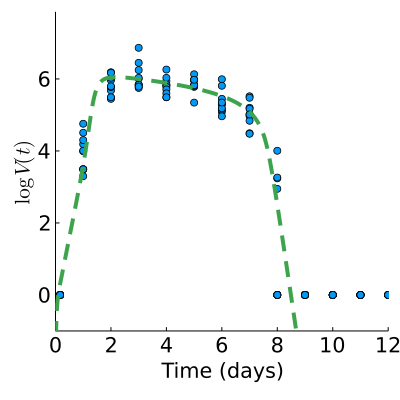

In [16]:
pt = plot(data)
plot!(pt, resultVTM, color=3)
savefig(figdir*"Smith2018ODEDataFit.pdf")
savefig(figdir*"Smith2018ODEDataFit.png")
display(pt)

### Comparing both models

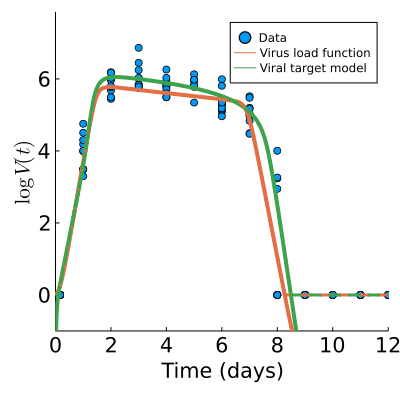

In [18]:
pt = plot(data, legend=true)
plot!(pt, resultVLF, color=2)
plot!(pt, resultVTM, linestyle=:solid, color=3)
plot!(pt, resultVLF, empirical=true, linestyle=:dash, linewidth=3, color=2, label=nothing)
plot!(pt, resultVTM, empirical=true, linestyle=:dash, linewidth=3, color=3, label=false)
savefig(figdir*"Smith2018DataFit.pdf")
savefig(figdir*"Smith2018DataFit.png")
display(pt)

In [19]:
summary(resultVLF)
summary(resultVTM)

RSS = 3.99685e+01
  a₁ = 8.787e-01 (initial=7.000e-01)
  a₂ = 2.049e+00 (initial=2.880e+00)
  b₁ = 6.244e+00 (initial=6.000e+00)
  b₂ = 7.588e+00 (initial=7.600e+00)
  α = 2.000e-01 (initial=2.000e-01)
  logVmax = 5.778e+00 (initial=5.000e+00)
RSS = 3.57378e+01 (convergence: true)
  β = 2.779e-04 (CI=(9.271e-05, 4.631e-04), initial=9.900e-05)
  δ = 1.532e+06 (CI=(1.368e+06, 1.696e+06), initial=1.600e+06)
  K = 3.128e+04 (CI=(-1.904e+03, 6.445e+04), initial=1.000e+05)
  p = 1.666e+00 (CI=(3.146e-02, 3.300e+00), initial=1.700e+00)
  c = 1.358e+01 (CI=(-2.264e+00, 2.942e+01), initial=1.200e+01)
